# Exploration and Preparation of the Retail Sales Data

## Step 1: Load and clean data

Load dependencies as well

In [1]:
# to keep the spam down
import warnings
warnings.filterwarnings('ignore')

# general data manipulation and viz
import pandas as pd # pandas v. >=0.23 required
import numpy as np
import matplotlib.pyplot as plt
import time

# for association rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# for customer clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# dimension reduction for visualization of results
from sklearn.decomposition import PCA

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

The data can be found here: https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo/home, which is also a pointer to the original source located here: https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

In [3]:
# decompress the .zip file from kaggle
# d_path = '/mnt/ubudata/projects/data/Online Retail.xlsx'
d_path = '/home/ahendel/projects/data/Online Retail.xlsx'
# d_path = '/Users/ahendel1/Downloads/Online Retail.xlsx'
sales = pd.read_excel(d_path)

In [4]:
# only want Invoices that do not start with a C
sales_mod = sales[[str(x)[0] not in ['C'] for x in sales.InvoiceNo]]
sales_mod.shape

(532621, 8)

In [38]:
sales_mod.CustomerID.nunique()

4339

In [5]:
sales_mod.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


There are duplicates in the data set. We will assume that duplicate items in a particular invoice are not erroneous, rather are an item that was stated twice (or more) in the checkout basket.

We could use either **StockCode** or **Description** as the products, so we will need to clean up any trailing white space on the descriptions and convert the **StockCode**s to strings.

In [6]:
def drop_pun(str_var):
    ignore="!\"#$%&\\'()*+,-./:;<=>?@[\\\\]^_`{|}~"
    str_cln=str_var.translate({ord(x): '' for x in ignore})
    return str_cln

In [7]:
sales_mod['Description'] = [drop_pun(str(x)) for x in sales_mod.Description]

In [8]:
sales_mod.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Step 2: Create Transactional Data Structure

create a list of lists. Each element in the list should consist of an invoice, and each invoice should contain the list of StockCodes' Descriptions. We will use descriptions instead of the codes, since the descriptions provide meaningful information to a human. StockCodes would have to be looked up to provide the same value.

In [39]:
trans = sales_mod.groupby(['InvoiceNo'])['Description'].agg(list)
trans = [x for x in trans if len(x) > 0] # drop invoices that had no items

In [40]:
# now transform it to a transactional data structure using mlxtend's implementation
# instantiate the encoder
te = TransactionEncoder()
# transform the data using the encoder
te_trans = te.fit(trans).transform(trans)
# convert back to a pandas dataframe for apriori
df = pd.DataFrame(te_trans, columns=te.columns_)

# Step 3: Conduct Association Rules

In [41]:
# fairly large dataset, so we will want low support
frequent_itemsets = apriori(
    df,
    min_support=0.01,
    use_colnames=True)

Each product is rather sparse in the dataset. With such large number of transactions and a large number of products, the support for any rule will be very low. Instead, we are more interested in confidence. Set min confidence to 0.7.

In [42]:
rules = association_rules(
    frequent_itemsets, 
    metric="confidence", 
    min_threshold=0.7)

In [44]:
# inspect the rules
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.010741,0.010877,0.010016,0.932489,85.726864,0.009899,14.651378
10,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.010877,0.010741,0.010016,0.920833,85.726864,0.009899,12.495897
125,(REGENCY TEA PLATE PINK),"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE G...",0.013823,0.014458,0.011557,0.836066,57.827432,0.011357,6.011807
122,"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE G...",(REGENCY TEA PLATE PINK),0.014458,0.013823,0.011557,0.799373,57.827432,0.011357,4.915474
123,"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE P...",(REGENCY TEA PLATE GREEN ),0.012192,0.017268,0.011557,0.947955,54.896818,0.011347,18.882494
22,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.013823,0.017268,0.012600,0.911475,52.784235,0.012361,11.101232
21,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.017268,0.013823,0.012600,0.729659,52.784235,0.012361,3.647896
19,(REGENCY SUGAR BOWL GREEN),(REGENCY MILK JUG PINK ),0.014594,0.014911,0.011013,0.754658,50.610281,0.010796,4.015172
18,(REGENCY MILK JUG PINK ),(REGENCY SUGAR BOWL GREEN),0.014911,0.014594,0.011013,0.738602,50.610281,0.010796,3.769751
119,"(POPPYS PLAYHOUSE KITCHEN, POPPYS PLAYHOUSE BE...",(POPPYS PLAYHOUSE LIVINGROOM ),0.014186,0.014866,0.010152,0.715655,48.140887,0.009941,3.464573


In [45]:
# save as a .csv
rules.to_csv('assoc_rules.csv',index=None)

In [13]:
# create a function to use to make a recommendation
def make_recommendation(product):
    result = rules[[product in x for x in rules.antecedents]][['consequents','lift']]
    return [list(x) for x in result[result.lift == max(result.lift)]['consequents']][0]

In [14]:
# test the function
# as we have it set up, the function will return a list of product recommendation(s)
make_recommendation('REGENCY TEA PLATE PINK')

['REGENCY TEA PLATE GREEN ', 'REGENCY TEA PLATE ROSES ']

# Step 4: Prepare for K-Means
Our intent is to cluster customers according to their purchasing behavior. For each customer, we will engineer the following features:
- total revenue over all time
- number of invoices over all time
- total value purchased by month of year
- number of units purchased by month of year
- unique number of products purchased over all time

In [11]:
# create a column for total revenue by purchase
sales_mod['total_rev'] = sales_mod.UnitPrice * sales_mod.Quantity

In [12]:
# create a dataframe for total revenue by customer
total_rev = sales_mod.groupby(['CustomerID'])['total_rev'].agg(sum).reset_index().set_index('CustomerID')
total_rev.head()

,total_rev
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [13]:
# create a month of year column
sales_mod['month'] = sales_mod.InvoiceDate.apply(lambda x: str(x)[5:7])

In [14]:
# create a dataframe with total spend by month per customer
cust_month = sales_mod.pivot_table(
    index='CustomerID', 
    columns='month',
    values='total_rev',
    aggfunc='sum',
    fill_value=0)
# prepend identifying text to the new columns
cust_month.columns = ['rev_mo_{}'.format(x) for x in cust_month.columns]
cust_month.head()

,rev_mo_01,rev_mo_02,rev_mo_03,rev_mo_04,rev_mo_05,rev_mo_06,rev_mo_07,rev_mo_08,rev_mo_09,rev_mo_10,rev_mo_11,rev_mo_12
CustomerID,,,,,,,,,,,,
12346.0,77183.60,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
12347.0,475.39,0.0,0.0,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,936.61
12348.0,227.44,0.0,0.0,367.00,0.0,0.00,0.0,0.00,310.0,0.00,0.00,892.80
12349.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1757.55,0.00
12350.0,0.00,334.4,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00


In [15]:
# create a dataframe with total units purchases per month
cust_units_month = sales_mod.pivot_table(
    index='CustomerID', 
    columns='month',
    values='Quantity',
    aggfunc='sum',
    fill_value=0)
# prepend identifying text to the new columns
cust_units_month.columns = ['units_mo_{}'.format(x) for x in cust_units_month.columns]
cust_units_month.head()

,units_mo_01,units_mo_02,units_mo_03,units_mo_04,units_mo_05,units_mo_06,units_mo_07,units_mo_08,units_mo_09,units_mo_10,units_mo_11,units_mo_12
CustomerID,,,,,,,,,,,,
12346.0,74215,0,0,0,0,0,0,0,0,0,0,0
12347.0,315,0,0,483,0,196,0,277,0,676,0,511
12348.0,601,0,0,269,0,0,0,0,217,0,0,1254
12349.0,0,0,0,0,0,0,0,0,0,0,631,0
12350.0,0,197,0,0,0,0,0,0,0,0,0,0


In [16]:
# create a dataframe for unique number of invoices by customer
num_invoices = sales_mod.groupby('CustomerID')[['InvoiceNo']].nunique()
# rename the column to something meaningful
num_invoices.rename(columns={'InvoiceNo' : 'num_invoices'},inplace=True)
num_invoices.head()

,num_invoices
CustomerID,
12346.0,1
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [17]:
# create a dataframe for unique number of products purchased by customer
unique_prods = sales_mod.groupby('CustomerID')[['StockCode']].nunique()
# rename the column to something meaningful
unique_prods.rename(columns={'StockCode' : 'num_unique_prods'},inplace=True)
unique_prods.head()

,num_unique_prods
CustomerID,
12346.0,1
12347.0,103
12348.0,22
12349.0,73
12350.0,17


In [18]:
# join the tables
# we are left with one row per customer, and columns for all the 28 variables we just created for each customer
joined = total_rev.join(num_invoices).join(cust_month, rsuffix='_mo_rev').join(cust_units_month, rsuffix='_mo_units').join(unique_prods)
joined.head()

,total_rev,num_invoices,rev_mo_01,rev_mo_02,rev_mo_03,rev_mo_04,rev_mo_05,rev_mo_06,rev_mo_07,rev_mo_08,rev_mo_09,rev_mo_10,rev_mo_11,rev_mo_12,units_mo_01,units_mo_02,units_mo_03,units_mo_04,units_mo_05,units_mo_06,units_mo_07,units_mo_08,units_mo_09,units_mo_10,units_mo_11,units_mo_12,num_unique_prods
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,77183.60,1,77183.60,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,74215,0,0,0,0,0,0,0,0,0,0,0,1
12347.0,4310.00,7,475.39,0.0,0.0,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,936.61,315,0,0,483,0,196,0,277,0,676,0,511,103
12348.0,1797.24,4,227.44,0.0,0.0,367.00,0.0,0.00,0.0,0.00,310.0,0.00,0.00,892.80,601,0,0,269,0,0,0,0,217,0,0,1254,22
12349.0,1757.55,1,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1757.55,0.00,0,0,0,0,0,0,0,0,0,0,631,0,73
12350.0,334.40,1,0.00,334.4,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0,197,0,0,0,0,0,0,0,0,0,0,17


In [19]:
# scale the variables using Z-score method
scaler = StandardScaler()
# scaler returns a matrix, but we want a dataframe and to retain the index names (rownames)
# so we will convert it back to a dataframe after transformation
joined_scaled = pd.DataFrame(
    scaler.fit_transform(joined),
    index=joined.index,
    columns=joined.columns)

In [20]:
joined_scaled.shape

(4339, 27)

In [21]:
joined_scaled.head()

,total_rev,num_invoices,rev_mo_01,rev_mo_02,rev_mo_03,rev_mo_04,rev_mo_05,rev_mo_06,rev_mo_07,rev_mo_08,rev_mo_09,rev_mo_10,rev_mo_11,rev_mo_12,units_mo_01,units_mo_02,units_mo_03,units_mo_04,units_mo_05,units_mo_06,units_mo_07,units_mo_08,units_mo_09,units_mo_10,units_mo_11,units_mo_12,num_unique_prods
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,8.359634,-0.424675,55.412345,-0.180258,-0.202689,-0.212160,-0.200167,-0.131968,-0.185888,-0.151321,-0.139424,-0.177775,-0.246421,-0.091070,61.575638,-0.156799,-0.191571,-0.169329,-0.194425,-0.161334,-0.219332,-0.142691,-0.190842,-0.195099,-0.257689,-0.102799,-0.708687
12347.0,0.251046,0.354080,0.247497,-0.180258,-0.202689,1.036151,-0.200167,0.199293,-0.185888,0.443774,-0.139424,0.782849,-0.246421,0.248194,0.194801,-0.156799,-0.191571,1.045039,-0.194425,0.215916,-0.219332,0.287202,-0.190842,0.768445,-0.257689,0.277278,0.486336
12348.0,-0.028546,-0.035297,0.069183,-0.180258,-0.202689,0.507887,-0.200167,-0.131968,-0.185888,-0.151321,0.057396,-0.177775,-0.246421,0.232325,0.432351,-0.156799,-0.191571,0.506996,-0.194425,-0.161334,-0.219332,-0.142691,0.138925,-0.195099,-0.257689,0.829914,-0.462653
12349.0,-0.032963,-0.424675,-0.094381,-0.180258,-0.202689,-0.212160,-0.200167,-0.131968,-0.185888,-0.151321,-0.139424,-0.177775,1.371054,-0.091070,-0.066835,-0.156799,-0.191571,-0.169329,-0.194425,-0.161334,-0.219332,-0.142691,-0.190842,-0.195099,0.776981,-0.102799,0.134858
12350.0,-0.191315,-0.424675,-0.094381,0.404679,-0.202689,-0.212160,-0.200167,-0.131968,-0.185888,-0.151321,-0.139424,-0.177775,-0.246421,-0.091070,-0.066835,0.347756,-0.191571,-0.169329,-0.194425,-0.161334,-0.219332,-0.142691,-0.190842,-0.195099,-0.257689,-0.102799,-0.521232


# Step 5: K-Means Clustering

In [22]:
# we arent sure how many clusters we need, so let's try up to 50
n_clusters = 50
# let's store the 'inertia' (sum of squared distances of samples to their closest cluster center) for each n_clusters
cluster_error = []
# we are also converted with the number of members per cluster, so let's store those for each n_cluster
value_counts = []

In [23]:
# now do KMeans for all values of n_clusters
start = time.time()
for clust in range(1,n_clusters):
    km = KMeans(n_clusters=clust, random_state=0).fit(joined_scaled)
    cluster_error.append(km.inertia_)
    value_counts.append(km.labels_)
    print(clust)
runtime = time.time() - start
print('Total Runtime: {} sec.'.format(round(runtime,2)))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Total Runtime: 36.17 sec.


In [48]:
pd.DataFrame(cluster_error).to_csv('elbow_plot.csv',index=None)

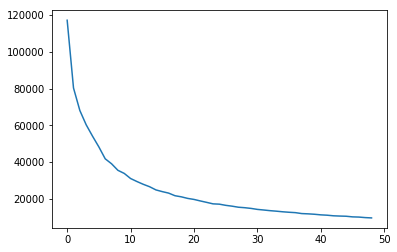

In [24]:
# 6 looks to be a good number of clusters
plt.plot(cluster_error)
plt.show()

In [25]:
# inspect the number of members per cluster for each number of K
for c in value_counts:
    print(pd.DataFrame(c)[0].value_counts())

# we see several clusters have only a single or handful of members
# why are those customers so much different that the others?

0    4339
Name: 0, dtype: int64
0    4327
1      12
Name: 0, dtype: int64
0    4301
1      32
2       6
Name: 0, dtype: int64
3    4301
0      31
1       6
2       1
Name: 0, dtype: int64
3    4301
0      30
1       6
2       1
4       1
Name: 0, dtype: int64
0    4178
2     145
1      13
3       1
5       1
4       1
Name: 0, dtype: int64
0    3969
6     343
2      19
1       5
3       1
5       1
4       1
Name: 0, dtype: int64
0    3822
7     476
4      26
1      10
6       2
3       1
2       1
5       1
Name: 0, dtype: int64
1    3861
0     441
5      22
6       6
3       3
8       3
7       1
2       1
4       1
Name: 0, dtype: int64
0    3836
5     463
8      20
9       8
1       5
4       3
7       1
3       1
6       1
2       1
Name: 0, dtype: int64
0     3737
8      554
4       31
6        6
9        3
1        3
7        1
3        1
10       1
2        1
5        1
Name: 0, dtype: int64
6     3459
0      772
3       83
9       12
1        4
11       3
7        1
10       1

In [26]:
# fit it again with the final number of clusters
clusts = 6
km = KMeans(n_clusters=clusts, random_state=0).fit(joined_scaled)

In [27]:
# we see several clusters have only a single or handful of members
pd.Series(km.labels_).value_counts()

0    4178
2     145
1      13
3       1
5       1
4       1
dtype: int64

In [28]:
# assign the labels back to the unscaled dataframe
joined['cluster'] = km.labels_

In [36]:
joined.dtypes

total_rev           float64
num_invoices          int64
rev_mo_01           float64
rev_mo_02           float64
rev_mo_03           float64
rev_mo_04           float64
rev_mo_05           float64
rev_mo_06           float64
rev_mo_07           float64
rev_mo_08           float64
rev_mo_09           float64
rev_mo_10           float64
rev_mo_11           float64
rev_mo_12           float64
units_mo_01           int64
units_mo_02           int64
units_mo_03           int64
units_mo_04           int64
units_mo_05           int64
units_mo_06           int64
units_mo_07           int64
units_mo_08           int64
units_mo_09           int64
units_mo_10           int64
units_mo_11           int64
units_mo_12           int64
num_unique_prods      int64
cluster               int32
dtype: object

In [30]:
# calculate useful descriptives for each of the clusters

# means
means = joined.groupby('cluster')[['total_rev','num_invoices','num_unique_prods']].agg('mean')
# make useful column names
means.columns = ['mean_{}'.format(x) for x in means.columns]

# standard deviations
sd = joined.groupby('cluster')[['total_rev','num_invoices','num_unique_prods']].agg('std')
# make useful column names
sd.columns = ['sd_{}'.format(x) for x in sd.columns]

# number of customers per cluster
num_members = pd.DataFrame(
    {'num_members' : pd.Series(km.labels_).value_counts().values},
    index = pd.Series(km.labels_).value_counts().index)

In [31]:
# now join those summary statistics into a single dataframe
summary = means.join(num_members).join(sd)
# then inspect the results
summary.sort_values('mean_total_rev')
# save to file for visualizations
summary.to_csv('summary.csv')

# Visualizations

In [32]:
# use PCA to reduce variable dimensions to 2, for scatter plot of clusters
pca = PCA(n_components=2)
pca_fit = pd.DataFrame(pca.fit_transform(joined_scaled),
                      columns=['PC1','PC2'],
                      index=km.labels_)
pca_fit.index.name = 'Cluster'

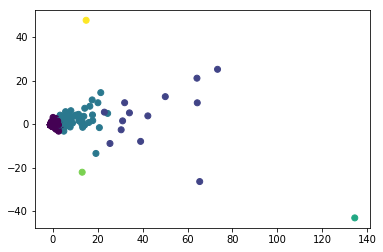

In [33]:
# quick check on meaningfulness
plt.scatter(pca_fit.PC1, pca_fit.PC2, c=pca_fit.index)
plt.show()

In [34]:
# save the centroids to a separate .csv
pca_fit.groupby('Cluster').agg('mean').to_csv('pca_centroids.csv')

In [35]:
# save as a .csv, for visualization in R/ggplot
pca_fit.to_csv('pca_results.csv')